# Demonstration of how to process Pseudo-JV data
Place raw data in directory titled "Data"  
Place SQ.csv and PowerCurrent_Averaged.csv in current working directory

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from natsort import natsorted

Load the data

In [2]:
def load_csv_data(data_dir):
    """Load CSV files from a directory and return them in a dictionary."""
    data = {}
    sample_names = natsorted(os.listdir(data_dir))

    for filename in sample_names:
        if filename.endswith(".csv") and "data" in filename.lower():
            sample_name = filename.rsplit("_data", 1)[0]

            # Load the data
            df = pd.read_csv(os.path.join(data_dir, filename))

            data[sample_name] = df

    return data

def add_power_column(data, ref):
    """Add a 'powers' column to each DataFrame based on the reference."""
    for name, df in data.items():
        current_range = np.arange(300, 800, 20)
        df['powers'] = np.array(ref['power'][current_range]) * 1000  # watts to mW

    return data

# Load in pJV data
data_dir = "Data"
data = load_csv_data(data_dir)
sample_names = natsorted(list(data.keys()))

# Load in reference files:
sq = pd.read_csv('SQ.csv', index_col='Eg')
ref = pd.read_csv('PowerCurrent_Averaged.csv', index_col='currents')
ref.index = np.round(ref.index, decimals=1)

# Add power column to data
data = add_power_column(data, ref)

Define constants and populate data dictionary

In [3]:
# Constants:
EMISSION_WL = 742  #modify this based on bandgap
LASER_SPOT_SIZE = 0.066 #cm2
kT = 0.026 #eV
REFLECTION_LOSSES = 0.10 # fraction of 1 taken off of the Jsc to make implied curve closer to reality, modify as needed
bandgap = np.round(1240/EMISSION_WL, decimals=2) # or set bandgap = value if known

# Populate data dictionary with shockley quisser limit data
for n in sample_names:
    data[n]['Eg'] = bandgap
    data[n]['Voc_rad'] = sq['Voc'][bandgap]
    data[n]['Jsc_rad'] = sq['Jsc'][bandgap]
    data[n]['Suns'] = (data[n]['powers']/LASER_SPOT_SIZE)/sq['laser power'][bandgap]  
    data[n]['qfls_rad'] = data[n]['Voc_rad'] + kT*np.log(data[n]['Suns'])
    data[n]['implied_current'] = data[n]['Jsc_rad']*(1-REFLECTION_LOSSES)*(1-data[n]['Suns'])
    data[n]['implied_current_limit'] = data[n]['Jsc_rad']*(1-data[n]['Suns'])

Plot Suns Voc

In [4]:
def plot_suns_voc(data, save_path=None):
    """Plot Suns vs. Voc for the provided data with error bars."""
    plt.figure(figsize=(8, 6), dpi=700)

    # Get a list of unique names in sample names
    sample_prefixes = list(set([name.split('_')[0] for name in data.keys()]))

    # Define a color map for the prefixes
    colors = plt.cm.get_cmap('tab10', len(sample_prefixes))

    # Iterate through each sample in the sorted order of data dictionary keys
    for i, sample_name in enumerate(sorted(data.keys())):
        sample_data = data[sample_name]

        # Extract relevant columns from the DataFrame
        x = sample_data['Voc'][1:]
        y = sample_data['Suns'][1:]
        err = sample_data['V_err'][1:]

        # Determine styling based on the sample name
        prefix = sample_name.split('_')[0]
        color = colors(sample_prefixes.index(prefix))
        line = '-' if sample_name.endswith('fwd') else ('--' if sample_name.endswith('rev') else '-.')
        marker = '.'

        # Compute linear fit for the current sample
        slope, intercept = np.polyfit(np.log(y), x, 1)

        # Compute ideality factor "n", divide slope by KbT
        n = slope / 0.0259

        # Plot 'Voc (V)' against 'Suns' with error bars and the ideality factor included in the label
        plt.errorbar(y, x, yerr=err, marker=marker, linestyle=line, 
                     label=f"{sample_name} (n={n:.2f})", capsize=3, color=color)

    # Plot Radiative Limit
    n = list(data.keys())[0]
    plt.plot(data[n]["Suns"], data[n]['qfls_rad'], label='Radiative Limit', color='gray')

    # Customize the plot
    plt.xlabel('Suns', fontsize=14)
    plt.xlim(1e-3,)
    plt.ylim(0,)
    plt.xscale("log")
    plt.ylabel('Voc (V)', fontsize=14)
    plt.title('Suns Voc', fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Save the plot if desired
    if save_path:
        plt.savefig(save_path)

/var/folders/b5/vvl66y7519qbwz7xvyw9l0wh0000gn/T/ipykernel_63654/3299651792.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(sample_prefixes))


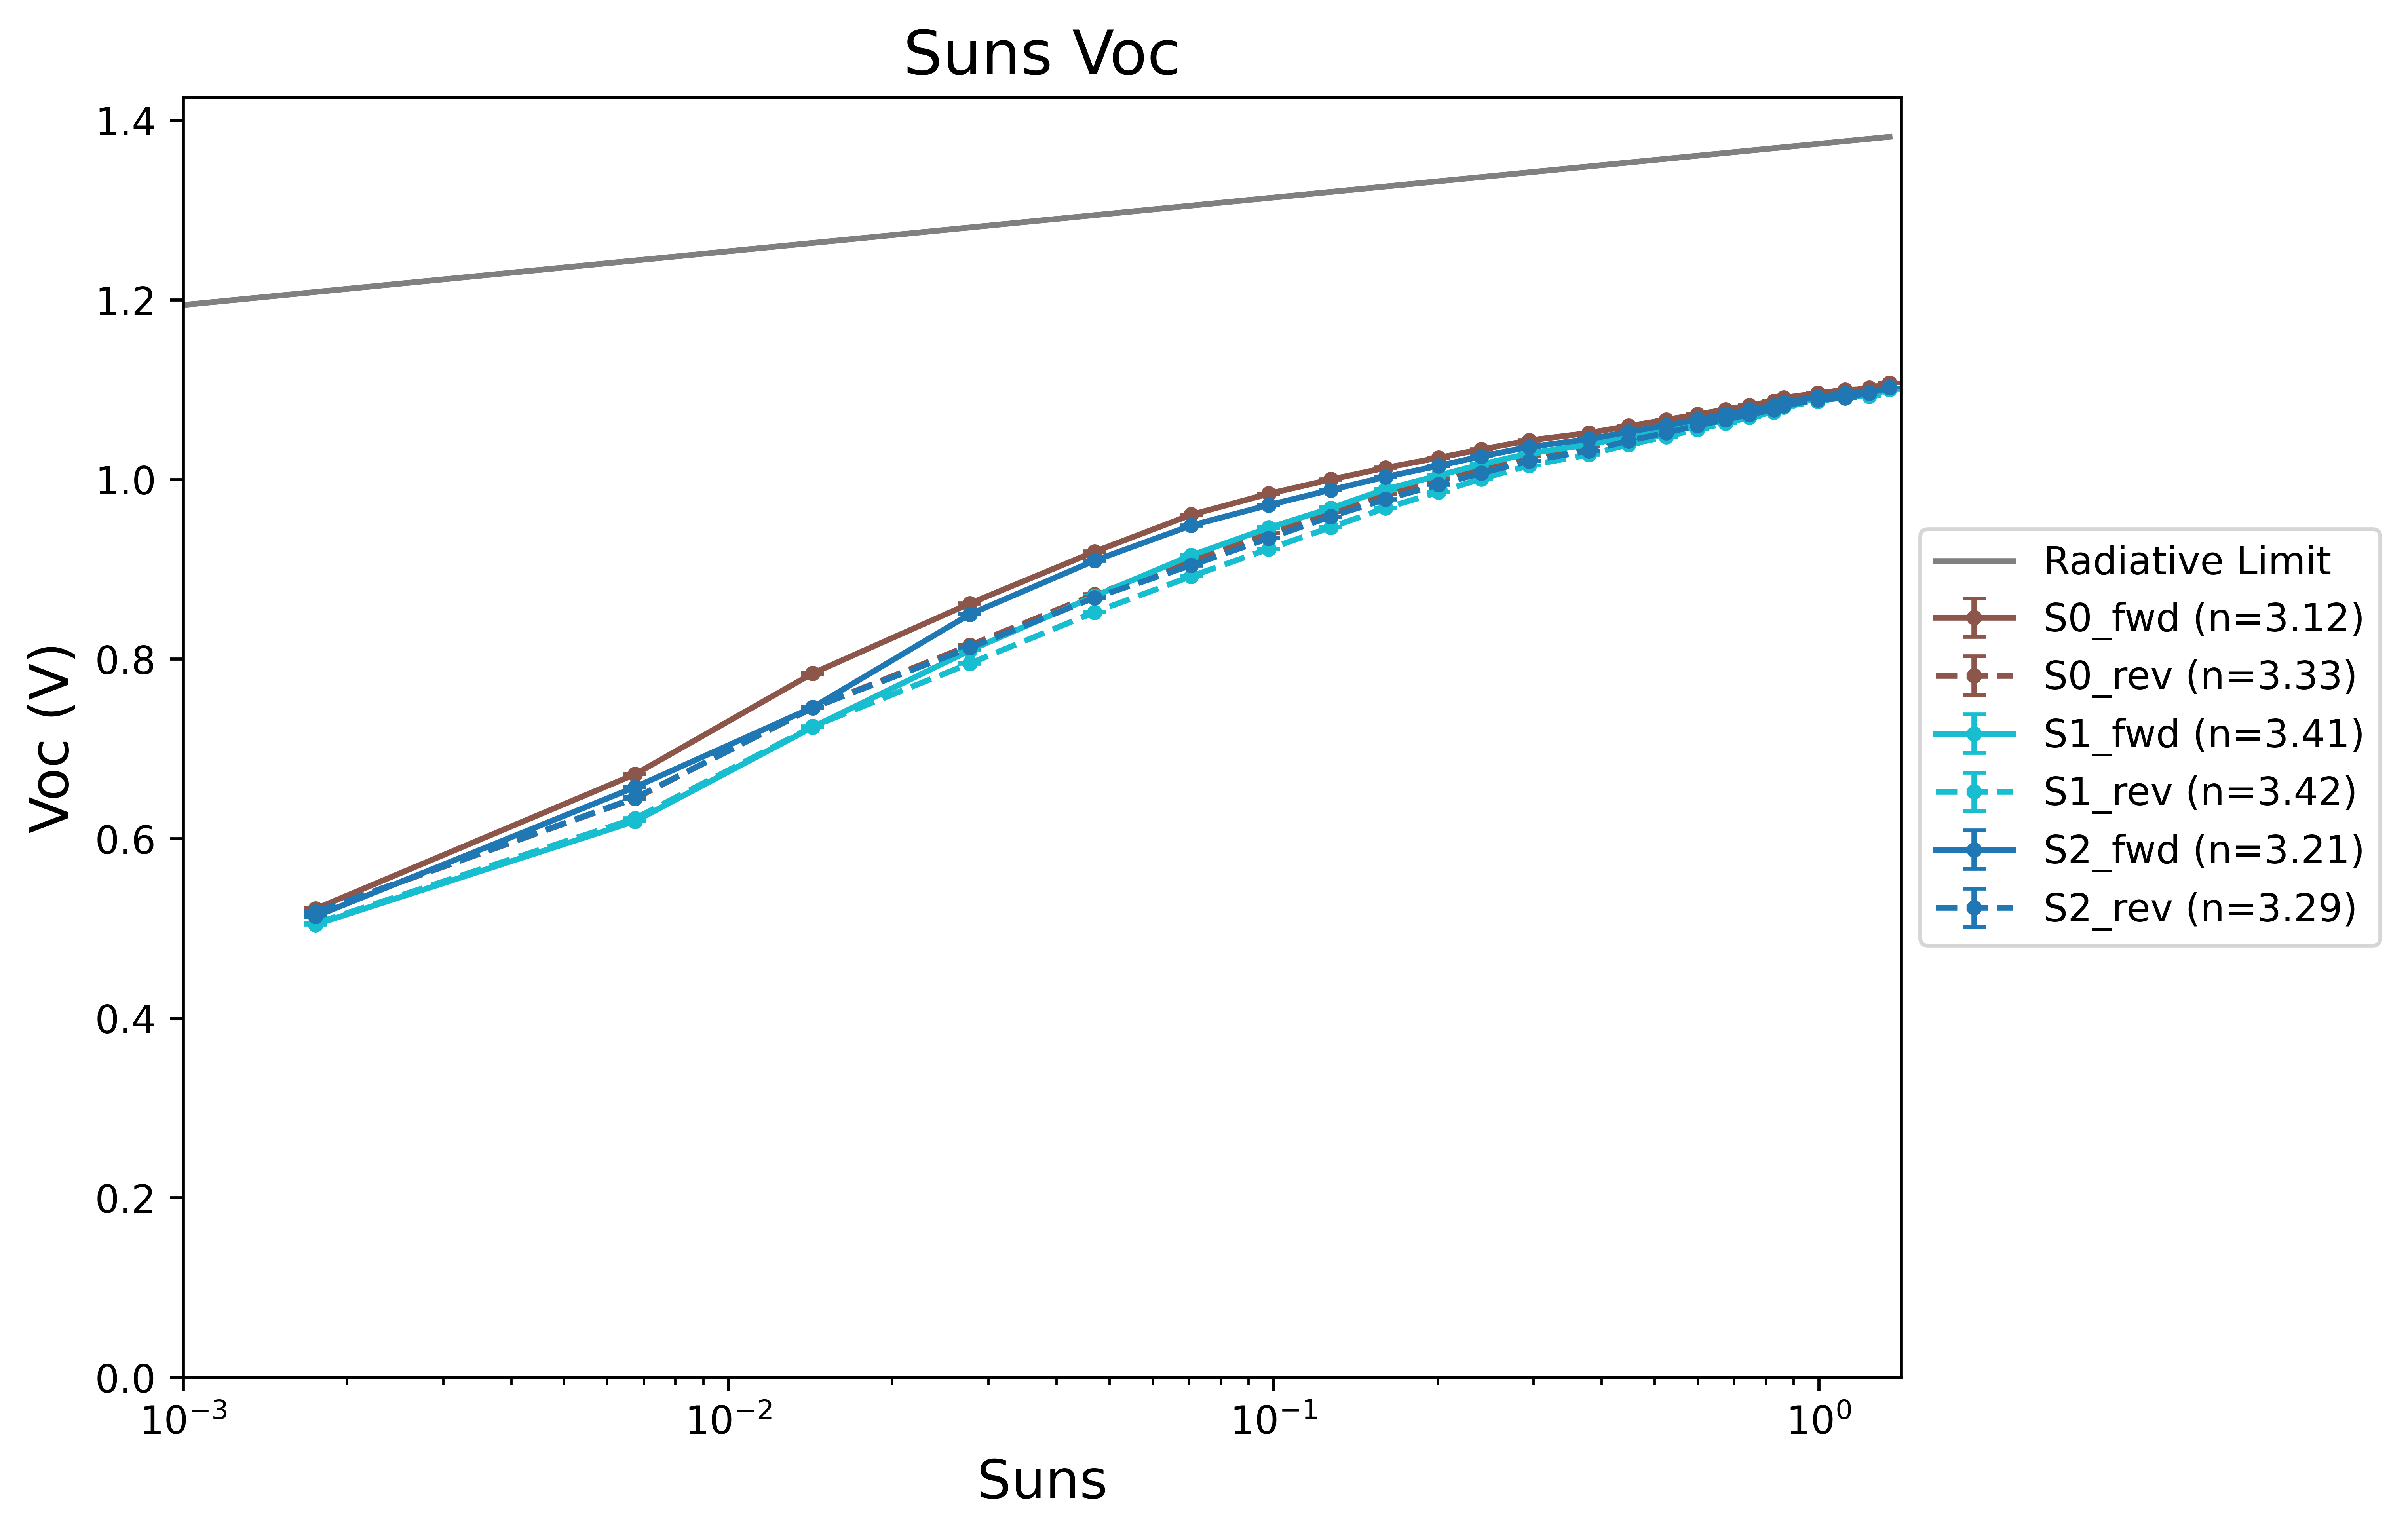

In [5]:
# Plot Suns Voc:
plot_suns_voc(data, "SunsVoc.png")

Plot pseudo-JV:

In [6]:
def plot_pJV(data, save_path=None):
    """Plot Suns vs. Voc for the provided data with error bars."""
    plt.figure(figsize=(8, 6), dpi=700)

    # Get a list of unique names in sample names
    sample_prefixes = list(set([name.split('_')[0] for name in data.keys()]))

    # Define a color map for the prefixes
    colors = plt.cm.get_cmap('tab10', len(sample_prefixes))

    # Iterate through each sample in the sorted order of data dictionary keys
    for i, sample_name in enumerate(sorted(data.keys())):
        sample_data = data[sample_name]

        # Extract relevant columns from the DataFrame
        x = sample_data['Voc'][:]
        y = sample_data['implied_current'][:]

        # Determine styling based on the sample name
        prefix = sample_name.split('_')[0]
        color = colors(sample_prefixes.index(prefix))
        line = '-' if sample_name.endswith('fwd') else ('--' if sample_name.endswith('rev') else '-.')
        plt.plot(x, y, linestyle = line, marker = '.', label=f"{sample_name}", color = color)
        

    # Plot Radiative Limit
    n = list(data.keys())[0]
    plt.plot(data[n]["qfls_rad"][:], data[n]['implied_current_limit'][:], label='Radiative Limit', color='gray')

    # Customize the plot
    plt.xlabel('Voltage (V)', fontsize=14)
    plt.ylim(0, 24)
    plt.ylabel(r'Pseudo Current Density $J$ (mA/cm$^{2}$)', fontsize=14)
    plt.title('Pseudo-JV', fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Save the plot if desired
    if save_path:
        plt.savefig(save_path)

/var/folders/b5/vvl66y7519qbwz7xvyw9l0wh0000gn/T/ipykernel_63654/2228753375.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(sample_prefixes))


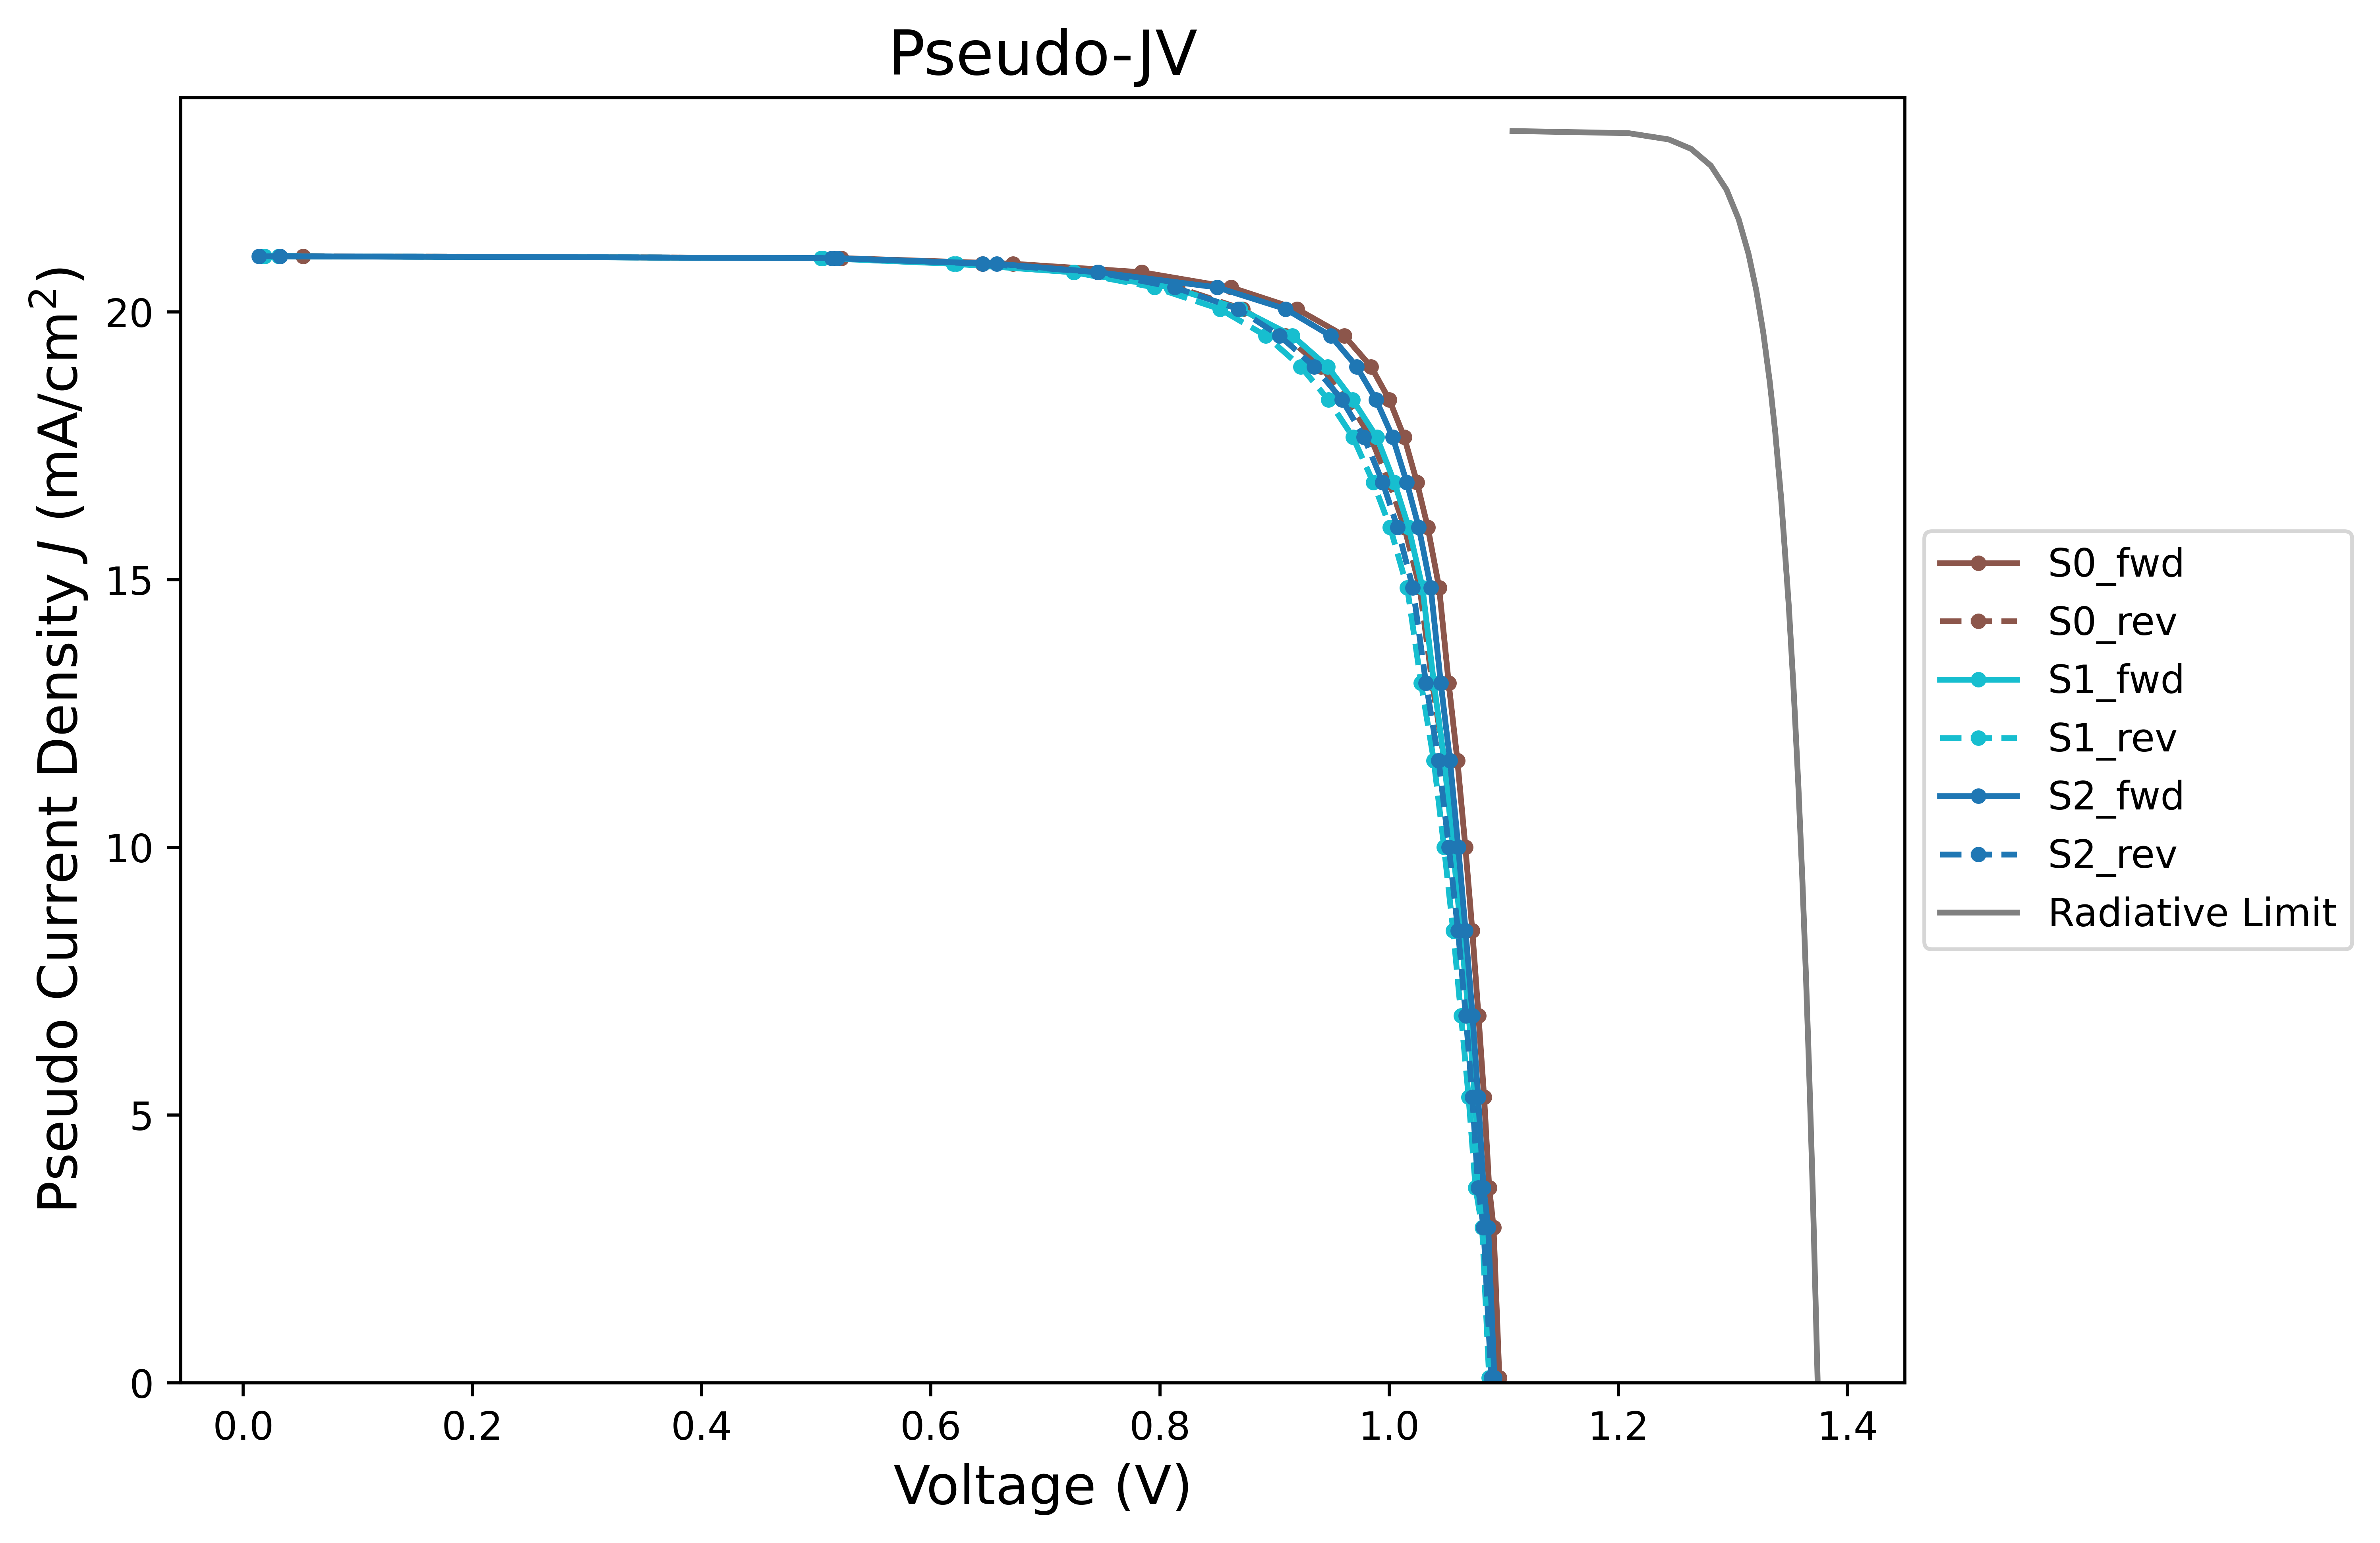

In [7]:
# Plot pseudo-JV:
plot_pJV(data, "PseudoJV.png")